## FAIRness evaluations in ORKG

In [184]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import itertools as it
from IPython.display import display
import requests
import time

pd.set_option('max_colwidth', 800)

In [185]:
# SPARQL Setup and Methods

# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://orkg.org/triplestore"

query = """## ORKG papers of the research field "Computer Sciences"
# Replace "orkgr:R132" for another research field 

PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>

SELECT ?paper ?paper_title ?doi
  WHERE {
    ?paper rdf:type orkgc:Paper ;
           rdfs:label ?paper_title ;
           orkgp:P30 orkgr:R132 
    OPTIONAL { ?paper orkgp:P26 ?doi } .
}

LIMIT 5"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def filter_dataframe_values(df):
    cols = df.columns.values.tolist()

    filter_cols = []
    rename_cols = {}
    for col_ind, col_name in enumerate(cols):
        if col_name.endswith(".value"):
            filter_cols.append(col_name)

            new_col_name = col_name.replace(".value", "")
            rename_cols[col_name] = new_col_name

    df = df.filter(items=filter_cols)
    df = df.rename(columns=rename_cols)

    return df

def read_dataframe_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    df = df.iloc[:,1:]
    return df

def get_sparql_results_as_df(endpoint_url, query):
    results = get_results(endpoint_url, query)
    results_json = results["results"]["bindings"]

    results_arr = np.array(results_json)
    df = pd.json_normalize(results_arr)
    df = filter_dataframe_values(df)

    return df

In [186]:
# Links data (ORKG URL, DOI, Standard URL) of all papers

query = """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>

SELECT ?paper ?paper_title ?research_field_label ?doi ?url
  WHERE {
    ?paper rdf:type orkgc:Paper ;
           rdfs:label ?paper_title ;
           orkgp:P30 ?research_field .
    
    ?research_field rdfs:label ?research_field_label .

    OPTIONAL { ?paper orkgp:P26 ?doi } .
    OPTIONAL { ?paper orkgp:url ?url } .
}
"""

paper_links_df = pd.DataFrame()
paper_links_csv_path = 'csv/0_papers_links.csv'

# Loads links data for all papers
if not os.path.exists(paper_links_csv_path):
  paper_links_df = get_sparql_results_as_df(endpoint_url, query)

  display(paper_links_df)

  os.makedirs('csv', exist_ok=True)
  paper_links_df.to_csv(paper_links_csv_path)
else:
  paper_links_df = read_dataframe_from_csv(paper_links_csv_path)

display(paper_links_df)

# List of ORKG URLs for all papers
orkg_urls = pd.unique(paper_links_df.iloc[:,0].tolist()).tolist()
orkg_urls.sort()


,paper,paper_title,research_field_label,doi,url
0,http://orkg.org/orkg/resource/R140371,An Approach For Transforming of Relational Databases to OWL Ontology,Artificial Intelligence,10.5121/ijwest.2015.6102,NaN
1,http://orkg.org/orkg/resource/R140383,Automatic Constructing OWL Ontology from Relational Database Schema:,Artificial Intelligence,10.5220/0004603100740081,NaN
2,http://orkg.org/orkg/resource/R140389,Database Analysis for Ontology Learning,Artificial Intelligence,10.1016/j.procs.2016.09.377,NaN
3,http://orkg.org/orkg/resource/R140479,Effect of surface chemistry on nanoparticle interaction with gastrointestinal mucus and distribution in the gastrointestinal tract following oral and rectal administration in the mouse,Medicinal Chemistry and Pharmaceutics,10.1016/j.jconrel.2014.10.026,NaN
4,http://orkg.org/orkg/resource/R140519,Sensing Behavior of Atomically Thin-Layered MoS2 Transistors,Analytical Chemistry,10.1021/nn400026u,https://pubs.acs.org/doi/abs/10.1021/nn400026u
...,...,...,...,...,...
24888,http://orkg.org/orkg/resource/R471117,Data-to-text Generation with Variational Sequential Planning,Computer Sciences,NaN,https://arxiv.org/abs/2202.13756v1.pdf
24889,http://orkg.org/orkg/resource/R471140,Stage-wise Fine-tuning for Graph-to-Text Generation,Computer Sciences,NaN,https://arxiv.org/abs/2105.08021v2.pdf
24890,http://orkg.org/orkg/resource/R471148,Investigating Pretrained Language Models for Graph-to-Text Generation,Computer Sciences,NaN,https://arxiv.org/abs/2007.08426v3.pdf
24891,http://orkg.org/orkg/resource/R471209,Text-to-Text Pre-Training for Data-to-Text Tasks,Computer Sciences,NaN,https://arxiv.org/abs/2005.10433v3.pdf


Research Fields: ['Artificial Intelligence', 'Medicinal Chemistry and Pharmaceutics', 'Analytical Chemistry', 'Earth Sciences', 'Urban Studies and Planning', 'Economics', 'Social Sciences', 'Natural Language Processing', 'Engineering', 'Digital Libraries', 'Oceanography', 'Atomic, Molecular and Optical Physics', 'Information Science', 'Genomics', 'Clinical Infectiology and Tropical Medicine', 'Materials Chemistry', 'Physical Chemistry', 'Organic Molecular Chemistry - Synthesis and Characterisation', 'Epidemiology', 'Immunology and Infectious Disease', 'Semantic Web', 'Databases/Information Systems', 'Ecology and Biodiversity of Animals and Ecosystems, Organismic Interactions', 'Nanoscience and Nanotechnology', 'Ecology and Evolutionary Biology', 'Machine Learning', 'Plasma and Beam Physics', 'Science', 'Mechanical Process Engineering', 'Control Theory', 'Physiology', 'Planetary Sciences', 'Computational Linguistics', 'Energy Systems', 'Human Computer Interfaces', 'Information Systems, 

Computer Sciences                                                      9817
Science                                                                3769
Bioinformatics                                                         1198
Ecology and Evolutionary Biology                                        980
Artificial Intelligence                                                 705
Software Engineering                                                    604
Semantic Web                                                            503
Information Science                                                     423
Natural Language Processing                                             400
Virology                                                                361
Computer and Systems Architecture                                       348
Operations Research, Systems Engineering and Industrial Engineering     346
Computational Neuroscience                                              323
Toxicology  

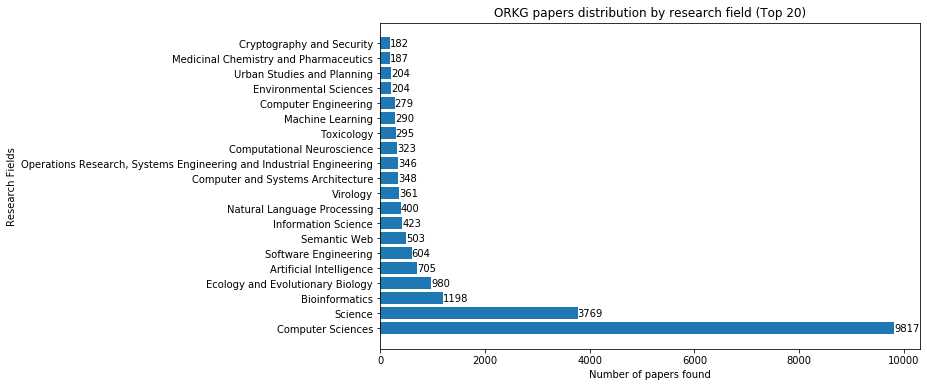

In [187]:
# List of unique research fields
research_fields = pd.unique(paper_links_df['research_field_label'].values).tolist()
research_fields_count = len(research_fields)
print(f'Research Fields: {research_fields}')
print(f'Number of unique research fields: {research_fields_count}')

# Papers counts of research fields
research_fields_total_paper_counts = paper_links_df['research_field_label'].value_counts()
top_20_rf_counts = research_fields_total_paper_counts.head(20)
display(top_20_rf_counts)

# Plot the counts
fig, ax = plt.subplots(figsize=(15, 6))
hbars = ax.barh(top_20_rf_counts.index, top_20_rf_counts.values)
ax.set_xlabel('Number of papers found')
ax.set_ylabel('Research Fields')
ax.set_title('ORKG papers distribution by research field (Top 20)')
ax.tick_params(axis='y', which='major', labelsize=10)

# Display papers count next to the horizontal bars
for hbar in hbars:
    width = hbar.get_width()
    y_pos = hbar.get_y() + hbar.get_height() / 2
    ax.text(width, y_pos, f'{width}', ha='left', va='center')

plt.subplots_adjust(left=0.4)   # left margin

os.makedirs('imgs', exist_ok=True)
plt.savefig("imgs/1_ORKG-papers-distribution-by-research-field_top-20.png")

plt.show()

In [188]:
# All papers metadata

query = """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>

SELECT ?paper ?paper_title ?doi ?url
       ?author ?venue ?venue_label
       ?publication_month ?publication_year
       ?research_field ?research_field_label
       ?contribution
  WHERE {
    ?paper rdf:type orkgc:Paper ;
           rdfs:label ?paper_title ;
           orkgp:P27 ?author ;
           orkgp:P30 ?research_field .

    ?research_field rdfs:label ?research_field_label .
    
    OPTIONAL { ?paper orkgp:P26 ?doi } .
    OPTIONAL { ?paper orkgp:url ?url } .
    OPTIONAL { ?paper orkgp:P28 ?publication_month } .
    OPTIONAL { ?paper orkgp:P29 ?publication_year } .
    OPTIONAL { ?paper orkgp:HAS_VENUE ?venue .
               ?venue rdfs:label ?venue_label } .
    OPTIONAL { ?paper orkgp:P31 ?contribution } .
}
"""

papers_metadata_df = pd.DataFrame()
papers_metadata_csv_path = 'csv/1_papers_metadata.csv'

if not os.path.exists(papers_metadata_csv_path):
       papers_metadata_df = get_sparql_results_as_df(endpoint_url, query)

       os.makedirs('csv', exist_ok=True)
       papers_metadata_df.to_csv(papers_metadata_csv_path)
else:
       papers_metadata_df = read_dataframe_from_csv(papers_metadata_csv_path)

display(papers_metadata_df)


,paper,paper_title,doi,url,author,venue,venue_label,publication_month,publication_year,research_field,research_field_label,contribution
0,http://orkg.org/orkg/resource/R141003,SemEval-2021 Task 5: Toxic Spans Detection,10.18653/v1/2021.semeval-1.6,https://aclanthology.org/2021.semeval-1.6.pdf,Ion Androutsopoulos,http://orkg.org/orkg/resource/R141004,Proceedings of the 15th International Workshop on Semantic Evaluation (SemEval-2021),8,2021,http://orkg.org/orkg/resource/R145261,Natural Language Processing,http://orkg.org/orkg/resource/R141005
1,http://orkg.org/orkg/resource/R141003,SemEval-2021 Task 5: Toxic Spans Detection,10.18653/v1/2021.semeval-1.6,https://aclanthology.org/2021.semeval-1.6.pdf,Jeffrey Sorensen,http://orkg.org/orkg/resource/R141004,Proceedings of the 15th International Workshop on Semantic Evaluation (SemEval-2021),8,2021,http://orkg.org/orkg/resource/R145261,Natural Language Processing,http://orkg.org/orkg/resource/R141005
2,http://orkg.org/orkg/resource/R141003,SemEval-2021 Task 5: Toxic Spans Detection,10.18653/v1/2021.semeval-1.6,https://aclanthology.org/2021.semeval-1.6.pdf,John Pavlopoulos,http://orkg.org/orkg/resource/R141004,Proceedings of the 15th International Workshop on Semantic Evaluation (SemEval-2021),8,2021,http://orkg.org/orkg/resource/R145261,Natural Language Processing,http://orkg.org/orkg/resource/R141005
3,http://orkg.org/orkg/resource/R141003,SemEval-2021 Task 5: Toxic Spans Detection,10.18653/v1/2021.semeval-1.6,https://aclanthology.org/2021.semeval-1.6.pdf,Léo Laugier,http://orkg.org/orkg/resource/R141004,Proceedings of the 15th International Workshop on Semantic Evaluation (SemEval-2021),8,2021,http://orkg.org/orkg/resource/R145261,Natural Language Processing,http://orkg.org/orkg/resource/R141005
4,http://orkg.org/orkg/resource/R141010,UnImplicit Shared Task Report: Detecting Clarification Requirements in Instructional Text,10.18653/v1/2021.unimplicit-1.4,https://aclanthology.org/2021.unimplicit-1.4.pdf,Michael Roth,http://orkg.org/orkg/resource/R141011,Proceedings of the 1st Workshop on Understanding Implicit and Underspecified Language,8,2021,http://orkg.org/orkg/resource/R145261,Natural Language Processing,http://orkg.org/orkg/resource/R141012
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,http://orkg.org/orkg/resource/R530648,Fine-grained Recognition: Accounting for Subtle Differences between Similar Classes,NaN,https://arxiv.org/abs/1912.06842v1.pdf,Fahad Shahbaz Khan,NaN,NaN,12,2019,http://orkg.org/orkg/resource/R132,Computer Sciences,http://orkg.org/orkg/resource/R530649
99996,http://orkg.org/orkg/resource/R530648,Fine-grained Recognition: Accounting for Subtle Differences between Similar Classes,NaN,https://arxiv.org/abs/1912.06842v1.pdf,Guolei Sun,NaN,NaN,12,2019,http://orkg.org/orkg/resource/R132,Computer Sciences,http://orkg.org/orkg/resource/R530649
99997,http://orkg.org/orkg/resource/R530648,Fine-grained Recognition: Accounting for Subtle Differences between Similar Classes,NaN,https://arxiv.org/abs/1912.06842v1.pdf,Ling Shao,NaN,NaN,12,2019,http://orkg.org/orkg/resource/R132,Computer Sciences,http://orkg.org/orkg/resource/R530649
99998,http://orkg.org/orkg/resource/R530648,Fine-grained Recognition: Accounting for Subtle Differences between Similar Classes,NaN,https://arxiv.org/abs/1912.06842v1.pdf,Salman Khan,NaN,NaN,12,2019,http://orkg.org/orkg/resource/R132,Computer Sciences,http://orkg.org/orkg/resource/R530649


,ORKG URLs,DOIs,Std. URLs,All Links
0,25070,11967,13978,3075


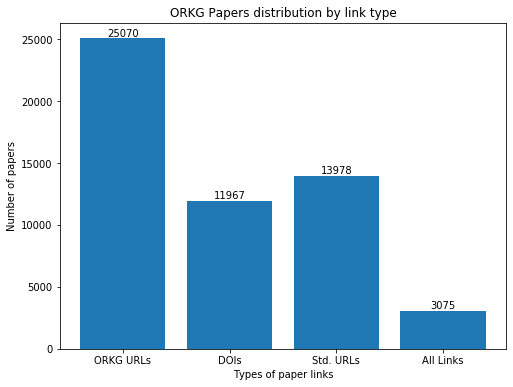

In [189]:
# Papers count distribution (All papers, DOIs, std. URLS)

query = """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>

SELECT ((COUNT(?resPaper)) AS ?total_ORKG_papers) ?DOIs ?standard_URLs ?complete_links
  WHERE {
    {
      SELECT DISTINCT ?resPaper
      WHERE {
        ?resPaper rdf:type orkgc:Paper ;
               rdfs:label ?paper_title .
        FILTER (STRLEN(?resPaper) > 0)
      }
    }
    {
      SELECT (COUNT(?paper) AS ?DOIs)
      WHERE {
        ?paper rdf:type orkgc:Paper ;
               rdfs:label ?paper_title ;
               orkgp:P26 ?doi .
        FILTER (STRLEN(?doi) > 0)
      }
    }
    {
      SELECT (COUNT(?paper) AS ?standard_URLs)
      WHERE {
        ?paper rdf:type orkgc:Paper ;
               rdfs:label ?paper_title ;
               orkgp:url ?url .
        FILTER (STRLEN(?url) > 0)
      }
    }
    {
      SELECT (COUNT(?paper) AS ?complete_links)
      WHERE {
        ?paper rdf:type orkgc:Paper ;
               rdfs:label ?paper_title ;
               orkgp:P26 ?doi ;
               orkgp:url ?url .
        FILTER (
          (STRLEN(?paper) > 0) &&
          (STRLEN(?doi) > 0) &&
          (STRLEN(?url) > 0)
        )
      }
    }
}
"""

# Extract papers count distribution by link type
papers_count_distribution_df = get_sparql_results_as_df(endpoint_url, query)
papers_count_distribution_csv_path = 'csv/2_papers_count_distribution.csv'

papers_count_distribution_df = papers_count_distribution_df.rename(
    columns={"total_ORKG_papers": "ORKG URLs", "standard_URLs": "Std. URLs", "complete_links": "All Links"})

display(papers_count_distribution_df)

os.makedirs('csv', exist_ok=True)
papers_count_distribution_df.to_csv(papers_count_distribution_csv_path)


# Plot papers count distribution as graph
plt.figure(figsize=(8, 6))

x_vals = papers_count_distribution_df.columns.values.tolist()
y_vals = list(map(int, papers_count_distribution_df.iloc[0].values.tolist()))

plt.bar(x_vals, y_vals)

for index, value in enumerate(y_vals):
    plt.text(index, value, str(value), ha="center", va="bottom")

plt.title("ORKG Papers distribution by link type")
plt.xlabel("Types of paper links")
plt.ylabel("Number of papers")

os.makedirs('imgs', exist_ok=True)
plt.savefig("imgs/2_ORKG-papers-distribution-by-link-type.png")

plt.show()


In [190]:
# TODO: (Ongoing) Identifying properties of ORKG papers

query = """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>

SELECT ?numResources ?numResearchProblems
WHERE {
    {
        SELECT (COUNT(?resources) AS ?numResources)
        WHERE {
        ?resources rdf:type orkgc:Resource;
                    rdfs:label ?resourceLabel .
        }
    }
    {
        SELECT (COUNT(?researchProblem) AS ?numResearchProblems)
        WHERE {
            ?researchProblem rdf:type orkgc:Problem .
        }
    }
}

"""

resources_count_df = get_sparql_results_as_df(endpoint_url, query)
resources_count_df = resources_count_df.rename(
    columns={"numResources.value": "resources", "numResearchProblems.value": "research problems"})

display(resources_count_df)

,numResources,numResearchProblems
0,357508,6072


#### Identifying Properties of ORKG Papers
##### Test results (ongoing):

* Number of ORKG Papers = *25070*
* Number of ORKG Resources = *357508*
* Number of ORKG Problems (Assumption: Research Problems) = *6072*

|Property            | Links to          |
|--------------------|-------------------|
|material            | orkgc:Resource    |
|method              | orkgc:Resource    |
|research problem    | orkgc:Problem     |
|result              | orkgc:Resource    |

In [191]:
ORKG_RESOURCE_BASE_URL = "https://www.orkg.org/resource"
FAIR_ENOUGH_API_URL = "https://api.fair-enough.semanticscience.org"
FAIR_ENOUGH_EVALUATIONS_URL = f'{FAIR_ENOUGH_API_URL}/evaluations'
FAIR_ENOUGH_METRICS_URL = f'{FAIR_ENOUGH_API_URL}/metrics'
FAIR_ENOUGH_COLLECTION_KEY = "fair-evaluator-maturity-indicators"
FAIR_ENOUGH_VALUE_URL_KEY = "http://semanticscience.org/resource/SIO_000300"

def get_fair_evaluator_metrics_as_df():
    fair_evaluator_metrics_df = pd.DataFrame()

    headers = {
        "accept": "application/json"
    }
    
    response = requests.get(FAIR_ENOUGH_METRICS_URL, headers=headers)
    metrics_json = response.json()

    fair_evaluator_metrics_info = [item for item in metrics_json if (item["_id"].startswith('https://w3id.org/FAIR_Tests/tests/'))]

    metrics_info = []
    for index, item in enumerate(fair_evaluator_metrics_info):
        id = f'{item["_id"]}'
        metric = f'{item["info"]["x-applies_to_principle"]}'
        title = f'{item["info"]["title"].replace("FAIR Metrics Gen2 - ", "").replace("FAIR Metrics Gen2- ", "")}'
        description = f'{item["info"]["description"]}'
        
        uid = f'{metric.lower()}_{id.replace("https://w3id.org/FAIR_Tests/tests/gen2_", "")}'

        curr_metrics_info = {
            "uid": f'{uid}',
            "id": f'{id}',
            "metric": f'{metric}',
            "title": f'{title}',
            "description": f'{description}',
        }

        metrics_info.append(curr_metrics_info)
    
    fair_evaluator_metrics_df = pd.json_normalize(metrics_info)

    return fair_evaluator_metrics_df


# Loads Fair Evaluator metrics info 
fair_evaluator_metrics_df = pd.DataFrame()
fair_evaluator_metrics_csv_path = "csv/3_fair_evaluator_metrics.csv"
if not os.path.exists(fair_evaluator_metrics_csv_path):
  fair_evaluator_metrics_df = get_fair_evaluator_metrics_as_df()

  os.makedirs('csv', exist_ok=True)
  fair_evaluator_metrics_df.to_csv(fair_evaluator_metrics_csv_path)
else:
  fair_evaluator_metrics_df = read_dataframe_from_csv(fair_evaluator_metrics_csv_path)

df = get_fair_evaluator_metrics_as_df()
display(fair_evaluator_metrics_df)

,uid,id,metric,title,description
0,f1_unique_identifier,https://w3id.org/FAIR_Tests/tests/gen2_unique_identifier,F1,Unique Identifier,Metric to test if the metadata resource has a unique identifier. This is done by comparing the GUID to the patterns (by regexp) of known GUID schemas such as URLs and DOIs. Known schema are registered in FAIRSharing (https://fairsharing.org/standards/?q=&selected_facets=type_exact:identifier%20schema)
1,f1_metadata_identifier_persistence,https://w3id.org/FAIR_Tests/tests/gen2_metadata_identifier_persistence,F1,Identifier Persistence,"Metric to test if the unique identifier of the metadata resource is likely to be persistent. Known schema are registered in FAIRSharing (https://fairsharing.org/standards/?q=&selected_facets=type_exact:identifier%20schema). For URLs that don't follow a schema in FAIRSharing we test known URL persistence schemas (purl, oclc, fdlp, purlz, w3id, ark)."
2,f1_data_identifier_persistence,https://w3id.org/FAIR_Tests/tests/gen2_data_identifier_persistence,F1,Data Identifier Persistence,"Metric to test if the unique identifier of the data resource is likely to be persistent. Known schema are registered in FAIRSharing (https://fairsharing.org/standards/?q=&selected_facets=type_exact:identifier%20schema). For URLs that don't follow a schema in FAIRSharing we test known URL persistence schemas (purl, oclc, fdlp, purlz, w3id, ark)."
3,f2_structured_metadata,https://w3id.org/FAIR_Tests/tests/gen2_structured_metadata,F2,Structured Metadata,"Tests whether a machine is able to find structured metadata. This could be (for example) RDFa, embedded json, json-ld, or content-negotiated structured metadata such as RDF Turtle"
4,f2_grounded_metadata,https://w3id.org/FAIR_Tests/tests/gen2_grounded_metadata,F2,Grounded Metadata,"Tests whether a machine is able to find 'grounded' metadata. i.e. metadata terms that are in a resolvable namespace, where resolution leads to a definition of the meaning of the term. Examples include JSON-LD, embedded schema, or any form of RDF. This test currently excludes XML, even when terms are namespaced. Future versions of this test may be more flexible."
5,a1.2_data_authorization,https://w3id.org/FAIR_Tests/tests/gen2_data_authorization,A1.2,Data authentication and authorization,"Test a discovered data GUID for the ability to implement authentication and authorization in its resolution protocol. Currently passes InChI Keys, DOIs, Handles, and URLs. It also searches the metadata for the Dublin Core 'accessRights' property, which may point to a document describing the data access process. Recognition of other identifiers will be added upon request by the community."
6,f3_data_identifier_in_metadata,https://w3id.org/FAIR_Tests/tests/gen2_data_identifier_in_metadata,F3,Data Identifier Explicitly In Metadata,"Metric to test if the metadata contains the unique identifier to the data. This is done by searching for a variety of properties, including foaf:primaryTopic, schema:mainEntity, schema:distribution, sio:is-about, and iao:is-about. schema codeRepository is used for software releases."
7,i1_data_kr_language_strong,https://w3id.org/FAIR_Tests/tests/gen2_data_kr_language_strong,I1,Data Knowledge Representation Language (strong),"Maturity Indicator to test if the data uses a formal language broadly applicable for knowledge representation. This particular test takes a broad view of what defines a 'knowledge representation language'; in this evaluation, a knowledge representation language is interpreted as one in which terms are semantically-grounded in ontologies. Any form of ontologically-grounded linked data will pass this test."
8,i1_data_kr_language_weak,https://w3id.org/FAIR_Tests/tests/gen2_data_kr_language_weak,I1,Data Knowledge Representation Language (weak),"Maturity Indicator to test if the data uses a formal language broadly applicable for knowledge representation. This particular test takes a broad view of what defines a 'knowledge representation langua

In [192]:
# Papers with complete links (non-empty ORKG URLs, DOIs and Standard URLs) ~ 3010 papers

query = """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>
    
SELECT ?paper ?doi ?url ?paper_title 
       ?research_field_label
  WHERE { 
    ?paper rdf:type orkgc:Paper;
           orkgp:P26 ?doi;
           orkgp:url ?url;
           rdfs:label ?paper_title ;
           orkgp:P30 ?research_field .
    
    ?research_field rdfs:label ?research_field_label .
    
    FILTER (
      (STRLEN(?paper) > 0) &&
      (STRLEN(?doi) > 0) &&
      (STRLEN(?url) > 0)
    )
}
"""

orkg_complete_papers_df = pd.DataFrame()
orkg_complete_papers_csv_path = 'csv/4_orkg_papers_complete_links.csv'

# Extract ORKG paper with complete links info
if not os.path.exists(orkg_complete_papers_csv_path):
    orkg_complete_papers_df = get_sparql_results_as_df(endpoint_url, query)
    
    os.makedirs('csv', exist_ok=True)
    orkg_complete_papers_df.to_csv(orkg_complete_papers_csv_path)
else:
    orkg_complete_papers_df = read_dataframe_from_csv(orkg_complete_papers_csv_path)


# Load API URIs for papers with complete links
api_orkg_urls = pd.unique(orkg_complete_papers_df.loc[:,'paper'].tolist()).tolist()
api_dois = pd.unique(orkg_complete_papers_df.loc[:,'doi'].tolist()).tolist()
api_std_urls = pd.unique(orkg_complete_papers_df.loc[:,'url'].tolist()).tolist()

print(f'Number of ORKG paper with complete links (non-empty ORKG, DOI and Standard URIs): {len(orkg_complete_papers_df.index)}')

display(orkg_complete_papers_df)

Number of ORKG paper with complete links (non-empty ORKG, DOI and Standard URIs): 3010


,paper,doi,url,paper_title,research_field_label
0,http://orkg.org/orkg/resource/R140519,10.1021/nn400026u,https://pubs.acs.org/doi/abs/10.1021/nn400026u,Sensing Behavior of Atomically Thin-Layered MoS2 Transistors,Analytical Chemistry
1,http://orkg.org/orkg/resource/R140522,10.1088/2053-1583/aa57fe,https://iopscience.iop.org/article/10.1088/2053-1583/aa57fe,Highly sensitive MoTe\n 2\n chemical sensor with fast recovery rate through gate biasing,Analytical Chemistry
2,http://orkg.org/orkg/resource/R140548,10.22606/gr.2017.23005,https://dx.doi.org/10.22606/gr.2017.23005,"ASTER Data Analyses for Lithological Discrimination of Sittampundi Anorthositic Complex, Southern India",Earth Sciences
3,http://orkg.org/orkg/resource/R140552,10.1007/s12594-016-0509-3,https://doi.org/10.1007/s12594-016-0509-3,Digital image processing of multispectral ASTER imagery for delineation of alteration and related clay minerals in Sakoli belt: Maharashtra – A case study,Earth Sciences
4,http://orkg.org/orkg/resource/R140556,10.18520/CS/V106/I1/40-49,https://www.currentscience.ac.in/Volumes/106/01/0040.pdf,"An image processing approach for converging ASTER-derived spectral maps for mapping Kolhan limestone, Jharkhand, India",Earth Sciences
...,...,...,...,...,...
3005,http://orkg.org/orkg/resource/R583543,10.1177/0278364908096316,http://dx.doi.org/10.1177/0278364908096316,3D Perception and Environment Map Generation for Humanoid Robot Navigation,Computer and Systems Architecture
3006,http://orkg.org/orkg/resource/R576000,10.1007/978-3-658-12307-9,http://dx.doi.org/10.1007/978-3-658-12307-9,Medienerziehung in Kindertagesstätten,Educational Research
3007,http://orkg.org/orkg/resource/R576010,10.1026/2191-9186/a000476,http://dx.doi.org/10.1026/2191-9186/a000476,Digitalisierung in Kindertageseinrichtungen: Ergebnisse einer empirischen Untersuchung zum Status quo,Educational Research
3008,http://orkg.org/orkg/resource/R576013,10.1026/2191-9186/a000176,http://dx.doi.org/10.1026/2191-9186/a000176,Eine Frage der Medienkompetenz?: Bedingungen medienpädagogischer Praxis in der Kindertageseinrichtung,Educational Research


In [193]:
def get_fair_evaluator_api_data(url, paper_type):
    try:
        found_paper_link = orkg_complete_papers_df.loc[orkg_complete_papers_df[paper_type].str.contains(url.replace("https://doi.org/", ""))]
        research_field_label = found_paper_link.iloc[0]['research_field_label']

        payload = {
            "subject": f"{url.strip()}",
            "collection": "fair-evaluator-maturity-indicators"
        }

        response = requests.post(FAIR_ENOUGH_EVALUATIONS_URL, json=payload)
        response_json = response.json()

        score = int(response_json["score"])
        score_max = int(response_json["score_max"])
        score_percent = round(float(response_json["score_percent"]), 2)
        
        fair_data = {
            "resource_url": f'{url}',
            "research_field": f'{research_field_label}',
            "fair_score": score,
            "fair_score_max": score_max,
            "fair_score_pct": score_percent,
            "findability_pct": 0,
            "accessibility_pct": 0,
            "interoperability_pct": 0,
            "reusability_pct": 0
        }

        findability_score = 0
        findability_max = 0

        accessibility_score = 0
        accessibility_max = 0

        interoperability_score = 0
        interoperability_max = 0

        reusability_score = 0
        reusability_max = 0

        contains = response_json["contains"]
        for key in contains.keys():
            row_df = fair_evaluator_metrics_df.loc[fair_evaluator_metrics_df['id']==key]
            
            metric = row_df.iloc[0]['uid']
            score = int(contains[key][0][FAIR_ENOUGH_VALUE_URL_KEY][0]["@value"])

            metric_char = metric[0].lower()
            if metric_char == 'f':
                if score == 1:
                    findability_score += 1
                findability_max += 1
            elif metric_char == 'a':
                if score == 1:
                    accessibility_score += 1
                accessibility_max += 1
            elif metric_char == 'i':
                if score == 1:
                    interoperability_score += 1
                interoperability_max += 1
            elif metric_char == 'r':
                if score == 1:
                    reusability_score += 1
                reusability_max += 1
            else:
                pass

            fair_data[metric] = score
        
        findability_pct = round((findability_score/findability_max)*100, 2) if (findability_max > 0) else 0
        accessibility_pct = round((accessibility_score/accessibility_max)*100, 2) if (accessibility_max > 0) else 0
        interoperability_pct = round((interoperability_score/interoperability_max)*100, 2) if (interoperability_max > 0) else 0
        reusability_pct = round((reusability_score/reusability_max)*100, 2) if (reusability_max > 0) else 0
        
        fair_data['findability_pct'] = findability_pct
        fair_data['accessibility_pct'] = accessibility_pct
        fair_data['interoperability_pct'] = interoperability_pct
        fair_data['reusability_pct'] = reusability_pct

        return fair_data
    except Exception as e:
        doi_https_prefix = 'https://doi.org'
        if (paper_type=='doi') and (not url.startswith(doi_https_prefix)):
            new_url = f'{doi_https_prefix}/{url}'
            return get_fair_evaluator_api_data(new_url, paper_type)
        else:
            print(f'Exception found for [{url}]: {e}')
            return None


In [194]:
def run_orkg_fairness_evaluations(uris, csv_path, paper_type='paper', api_mode=True):
    fair_evaluator_api_data_df = pd.DataFrame()

    if (api_mode==True):
        fair_api_data = []

        start_time = time.time()

        for api_url in uris:
            # Fetch FAIR Evaluations for given URI and link type
            fair_api_data_item = get_fair_evaluator_api_data(api_url, paper_type)
            if fair_api_data_item is not None:
                fair_api_data.append(fair_api_data_item)
        
        fair_evaluator_api_data_df = pd.json_normalize(fair_api_data)

        os.makedirs('csv', exist_ok=True)
        fair_evaluator_api_data_df.to_csv(csv_path, mode='a', header=not os.path.exists(csv_path))
        fair_evaluator_api_data_df = read_dataframe_from_csv(csv_path)

        # Drop duplicate entries in the dataframe
        fair_evaluator_api_data_df = fair_evaluator_api_data_df.drop_duplicates(subset=['resource_url'])
        # Reset indices
        fair_evaluator_api_data_df.reset_index(drop=True, inplace=True)
        # Rewrite and reread csv file
        fair_evaluator_api_data_df.to_csv(csv_path)
        fair_evaluator_api_data_df = read_dataframe_from_csv(csv_path)

        elapsed = time.time() - start_time
        print(f"Elapsed time: {elapsed:.2f}s")
    elif os.path.exists(csv_path):
        fair_evaluator_api_data_df = read_dataframe_from_csv(csv_path)

    return fair_evaluator_api_data_df


In [195]:
# Determines if fairness data should be loaded by API calls or from saved CSV files
API_MODE = False

# Number of papers to slice for API calls
ALL_PAPERS_API = False
NUM_PAPERS_API = 10

# CSV Paths of saved fairness data
orkg_uris_csv_path = 'csv/5_fairness_evaluations_orkg_uris.csv'
doi_uris_csv_path = 'csv/5_fairness_evaluations_doi_uris.csv'
std_uris_csv_path = 'csv/5_fairness_evaluations_std_uris.csv'

# Create copies of URIs
orkg_uris = api_orkg_urls.copy()
doi_uris = api_dois.copy()
std_uris = api_std_urls.copy()

# Exclude previously evaluated URIs to avoid repeated evaluations
if os.path.exists(orkg_uris_csv_path):
    evaluated_orkg_uris_df = read_dataframe_from_csv(orkg_uris_csv_path)
    evaluated_orkg_uris = evaluated_orkg_uris_df.loc[:,'resource_url'].tolist()
    # Filter and remove already evaluated ORKG URIs
    orkg_uris = [uri for uri in orkg_uris if uri not in evaluated_orkg_uris]
if os.path.exists(doi_uris_csv_path):
    evaluated_doi_uris_df = read_dataframe_from_csv(doi_uris_csv_path)
    evaluated_doi_uris = evaluated_doi_uris_df.loc[:,'resource_url'].tolist()
    # Filter and remove already evaluated DOI URIs
    doi_uris = [uri for uri in doi_uris if uri not in evaluated_doi_uris]
if os.path.exists(std_uris_csv_path):
    evaluated_std_uris_df = read_dataframe_from_csv(std_uris_csv_path)
    evaluated_std_uris = evaluated_std_uris_df.loc[:,'resource_url'].tolist()
    # Filter and remove already evaluated standard URIs
    std_uris = [uri for uri in std_uris if uri not in evaluated_std_uris]

# Sliced URIs for API calls
orkg_uris = orkg_uris[:NUM_PAPERS_API] if not ALL_PAPERS_API else orkg_uris
doi_uris = doi_uris[:NUM_PAPERS_API] if not ALL_PAPERS_API else doi_uris
std_uris = std_uris[:NUM_PAPERS_API] if not ALL_PAPERS_API else std_uris

# Paper types
ORKG_URI_MODE = 'paper'
DOI_URI_MODE = 'doi'
STD_URI_MODE = 'url'


In [196]:
# Run ORKG Fairness evaluations for Standard URLs of papers with complete links
std_uris_fairness_df = pd.DataFrame()
if len(std_uris) > 0:
    std_uris_fairness_df = run_orkg_fairness_evaluations(std_uris, std_uris_csv_path, STD_URI_MODE, API_MODE)
else:
    std_uris_fairness_df = read_dataframe_from_csv(std_uris_csv_path)
display(std_uris_fairness_df)

,resource_url,research_field,fair_score,fair_score_max,fair_score_pct,findability_pct,accessibility_pct,interoperability_pct,reusability_pct,f1_unique_identifier,...,i1_metadata_kr_language_strong,a1.2_metadata_authorization,f2_grounded_metadata,r1.1_metadata_includes_license_strong,a1.2_data_authorization,i1_metadata_kr_language_weak,i3_metadata_contains_outward_links,a1.1_metadata_protocol,i2_metadata_uses_fair_vocabularies_weak,f4_searchable
0,https://pubs.acs.org/doi/abs/10.1021/nn400026u,Analytical Chemistry,3,22,13.64,12.5,40.0,0.00,0.0,1,...,0,1,0,0,0,0,0,1,0,0
1,https://iopscience.iop.org/article/10.1088/2053-1583/aa57fe,Analytical Chemistry,3,22,13.64,12.5,40.0,0.00,0.0,1,...,0,1,0,0,0,0,0,1,0,0
2,https://dx.doi.org/10.22606/gr.2017.23005,Earth Sciences,9,22,40.91,50.0,40.0,42.86,0.0,1,...,1,1,1,0,0,1,1,1,0,0
3,https://doi.org/10.1007/s12594-016-0509-3,Earth Sciences,10,22,45.45,50.0,40.0,57.14,0.0,1,...,1,1,1,0,0,1,1,1,1,0
4,https://www.currentscience.ac.in/Volumes/106/01/0040.pdf,Earth Sciences,8,22,36.36,37.5,40.0,42.86,0.0,1,...,1,1,1,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,https://ieeexplore.ieee.org/abstract/document/9293166,Engineering,3,22,13.64,12.5,40.0,0.00,0.0,0,...,0,0,0,0,0,0,0,0,0,0
96,https://pubmed.ncbi.nlm.nih.gov/29480735/,Epidemiology,7,22,31.82,37.5,40.0,28.57,0.0,0,...,0,0,0,1,1,0,0,0,0,0
97,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6667360/,Epidemiology,3,22,13.64,12.5,40.0,0.00,0.0,0,...,0,0,0,0,0,0,0,0,0,0
98,https://aclanthology.org/2020.sigmorphon-1.1.pdf,Artificial Intelligence,8,22,36.36,37.5,40.0,42.86,0.0,1,...,1,0,0,1,1,0,1,0,0,0


In [197]:
# Run ORKG Fairness evaluations for DOIs of papers with complete links
doi_uris_fairness_df = pd.DataFrame()
if len(doi_uris) > 0:
    doi_uris_fairness_df = run_orkg_fairness_evaluations(doi_uris, doi_uris_csv_path, DOI_URI_MODE, API_MODE)
else:
    doi_uris_fairness_df = read_dataframe_from_csv(doi_uris_csv_path)
display(doi_uris_fairness_df)

,resource_url,research_field,fair_score,fair_score_max,fair_score_pct,findability_pct,accessibility_pct,interoperability_pct,reusability_pct,f1_metadata_identifier_persistence,...,i2_metadata_uses_fair_vocabularies_strong,r1.1_metadata_includes_license_weak,f3_data_identifier_in_metadata,f1_data_identifier_persistence,i1_metadata_kr_language_strong,a2_metadata_persistence,r1.1_metadata_includes_license_strong,a1.1_metadata_protocol,i2_metadata_uses_fair_vocabularies_weak,f4_searchable
0,10.1021/nn400026u,Analytical Chemistry,4,22,18.18,25.0,40.0,0.00,0.0,1,...,0,0,0,0,0,0,0,1,0,0
1,10.22606/gr.2017.23005,Earth Sciences,10,22,45.45,62.5,40.0,42.86,0.0,1,...,0,0,0,0,1,0,0,1,0,0
2,10.1007/s12594-016-0509-3,Earth Sciences,11,22,50.00,62.5,40.0,57.14,0.0,1,...,0,0,0,0,1,0,0,1,1,0
3,10.18520/CS/V106/I1/40-49,Earth Sciences,4,22,18.18,25.0,40.0,0.00,0.0,1,...,0,0,0,0,0,0,0,1,0,0
4,10.1016/j.jseaes.2011.01.004,Earth Sciences,12,22,54.55,62.5,40.0,71.43,0.0,1,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,10.1109/jsen.2021.3077274,Engineering,4,22,18.18,25.0,40.0,0.00,0.0,1,...,0,0,0,0,0,0,0,0,0,0
98,10.3389/fmicb.2012.00386,Oceanography,10,22,45.45,62.5,40.0,42.86,0.0,1,...,0,1,0,0,1,1,0,0,0,0
99,10.1039/c3dt53305k,Engineering,12,22,54.55,62.5,40.0,71.43,0.0,1,...,1,1,0,0,1,1,0,0,1,0
100,10.1007/s10854-016-4993-4,Engineering,11,22,50.00,62.5,40.0,57.14,0.0,1,...,0,1,0,0,1,1,0,0,1,0


In [198]:
# Run ORKG Fairness evaluations for ORKG URLs of papers with complete links
orkg_uris_fairness_df = pd.DataFrame()
if len(orkg_uris) > 0:
    orkg_uris_fairness_df = run_orkg_fairness_evaluations(orkg_uris, orkg_uris_csv_path, ORKG_URI_MODE, API_MODE)
else:
    orkg_uris_fairness_df = read_dataframe_from_csv(orkg_uris_csv_path)
display(orkg_uris_fairness_df)

,resource_url,research_field,fair_score,fair_score_max,fair_score_pct,findability_pct,accessibility_pct,interoperability_pct,reusability_pct,f1_unique_identifier,...,f3_metadata_identifier_in_metadata,r1.1_metadata_includes_license_strong,a2_metadata_persistence,i1_metadata_kr_language_weak,i1_metadata_kr_language_strong,r1.1_metadata_includes_license_weak,f4_searchable,a1.1_metadata_protocol,i2_metadata_uses_fair_vocabularies_weak,i2_metadata_uses_fair_vocabularies_strong
0,http://orkg.org/orkg/resource/R140519,Analytical Chemistry,7,22,31.82,37.5,40.0,28.57,0.0,1,...,0,0,0,1,1,0,0,1,0,0
1,http://orkg.org/orkg/resource/R140522,Analytical Chemistry,7,22,31.82,37.5,40.0,28.57,0.0,1,...,0,0,0,1,1,0,0,1,0,0
2,http://orkg.org/orkg/resource/R140548,Earth Sciences,7,22,31.82,37.5,40.0,28.57,0.0,1,...,0,0,0,1,1,0,0,1,0,0
3,http://orkg.org/orkg/resource/R140552,Earth Sciences,7,22,31.82,37.5,40.0,28.57,0.0,1,...,0,0,0,1,1,0,0,1,0,0
4,http://orkg.org/orkg/resource/R140556,Earth Sciences,7,22,31.82,37.5,40.0,28.57,0.0,1,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,http://orkg.org/orkg/resource/R142214,Materials Chemistry,7,22,31.82,37.5,40.0,28.57,0.0,0,...,0,1,0,0,1,0,1,0,0,0
112,http://orkg.org/orkg/resource/R142218,Materials Chemistry,7,22,31.82,37.5,40.0,28.57,0.0,0,...,0,1,0,0,1,0,1,0,0,0
113,http://orkg.org/orkg/resource/R142221,Materials Chemistry,7,22,31.82,37.5,40.0,28.57,0.0,0,...,0,1,0,0,1,0,1,0,0,0
114,http://orkg.org/orkg/resource/R142225,Materials Chemistry,7,22,31.82,37.5,40.0,28.57,0.0,0,...,0,1,0,0,1,0,1,0,0,0


In [207]:
def calculate_boxplot_data(data):
    # Calculate the required statistics
    median = np.median(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lw = np.min([item for item in data if item >= (q1 - 1.5 * iqr)])
    uw = np.max([item for item in data if item <= (q3 + 1.5 * iqr)])

    # Create the box plot data
    box_data = [median, q1, q3, lw, uw]
    return box_data


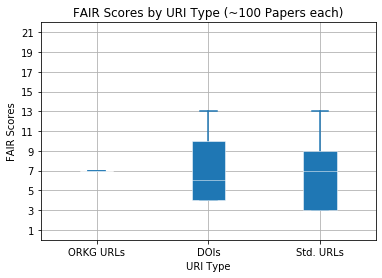

In [209]:
orkg_uri_fair_scores = np.array(orkg_uris_fairness_df['fair_score'].tolist()).astype(int).tolist()
orkg_uri_fair_scores_boxplot = calculate_boxplot_data(orkg_uri_fair_scores)

doi_uri_fair_scores = np.array(doi_uris_fairness_df['fair_score'].tolist()).astype(int)
doi_uri_fair_scores_boxplot = calculate_boxplot_data(doi_uri_fair_scores)

std_uri_fair_scores = np.array(std_uris_fairness_df['fair_score'].tolist()).astype(int)
std_uri_fair_scores_boxplot = calculate_boxplot_data(std_uri_fair_scores)

fair_scores_boxplot_data = [orkg_uri_fair_scores_boxplot, doi_uri_fair_scores_boxplot, std_uri_fair_scores_boxplot]

fig, ax = plt.subplots()
ax.boxplot(fair_scores_boxplot_data, patch_artist=True,
                showmeans=False, showfliers=False,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})

ax.set_title('FAIR Scores by URI Type (~100 Papers each)')
ax.set_xlabel('URI Type')
ax.set_ylabel('FAIR Scores')

ax.set_xticklabels(['ORKG URLs', 'DOIs', 'Std. URLs'])
ax.set(ylim=(0, 22), yticks=np.arange(1, 22, 2))

plt.grid(True)

os.makedirs('imgs', exist_ok=True)
plt.savefig("imgs/3_ORKG-FAIR-Scores-by-URI-Type_for-sample-100-papers.png")

plt.show()
